In [1]:
import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

    def print(self):
        print(self.data + " "+ self.creator.name + " " + str(self.height))
    
class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        r = random.choices(maxes, k=1)
        return r[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        
    def print(self):
        for block in self.chain:
            block.print()
            print("________")

    def hasFork(self):
        for block1 in self.chain:
            for block2 in self.chain:
                if block1!=block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
    
    # miner A - how many blocks are built on top of the blocks of miner A?
    def gammaMiner(self, miner): 
        last = self.longestChain()
        count = 0 # block 0 (miner A) -> block 1 (miner B) -> block 2 (miner A)
        while last!=None:
            last_creator =  last.creator
            if last_creator != miner and last.previous.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        #add this function - selfish PoW
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

    def attackerHasControl(blockchain, attacker):
        if blockchain.longestChain().creator == attacker:
            return True
        return False

In [2]:
def make_miners_A(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

def simulate_selfish_mining(bc, legal_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in legal_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in legal_miners:
            m.UpdateLast()
    
    selfish_profit = 0
    bc_height = bc.longestChain().height
    for miner in selfish_miners:
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        selfish_profit += percentage_of_miner_blocks
    
    honest_profit = 0
    for legal_miner in legal_miners:
        percentage_of_miner_blocks = bc.checkMiner(legal_miner) / bc_height
        honest_profit += percentage_of_miner_blocks
        
    return selfish_profit, honest_profit

In [58]:
### Modelling 99 honest miners and 1 selfish miner
### increasing the mining power of the one selfish miner

import matplotlib.pyplot as plt

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for selfish_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round((100-selfish_power)/100, 2) 
    selfish_power_share = round(selfish_power/100, 2) 
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    bc = Blockchain("0" , 11)

    honest_miners = make_miners_A("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners_A("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
    
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()

Running simulation of mining power with:
-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
...
Honest profit: 0.9999999999999997
Selfish profit: 0.0
Total profit: 0.9999999999999997

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 98% of total mining power
-> 1 selfish minors having 2% of total mining power
...
Honest profit: 0.9999999999999994
Selfish profit: 0.0
Total profit: 0.9999999999999994

Running simulation of mining power with:
-> 99 honest minors having 97% of total mining power
-> 1 selfish minors having 3% of total mining power
...
Honest profit: 0.9680851063829777
Selfish profit: 0.031914893617021274
Total profit: 0.999999999999999

Running simulation of mining po

Honest profit: 0.8488372093023262
Selfish profit: 0.1511627906976744
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 67% of total mining power
-> 1 selfish minors having 33% of total mining power
...
Honest profit: 0.618421052631579
Selfish profit: 0.3815789473684211
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 66% of total mining power
-> 1 selfish minors having 34% of total mining power
...
Honest profit: 0.6282051282051282
Selfish profit: 0.3717948717948718
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 65% of total mining power
-> 1 selfish minors having 35% of total mining power
...
Honest profit: 0.8048780487804883
Selfish profit: 0.1951219512195122
Total profit: 1.0000000000000004

Running simulation of mining power with:
-> 99 honest minors having 64% of total mining power
-> 1 selfish minors having 36% of total mining power
...
Honest profit: 

Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 32% of total mining power
-> 1 selfish minors having 68% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 31% of total mining power
-> 1 selfish minors having 69% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 30% of total mining power
-> 1 selfish minors having 70% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 29% of total mining power
-> 1 selfish minors having 71% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 28% of total mining power
-> 1 selfish

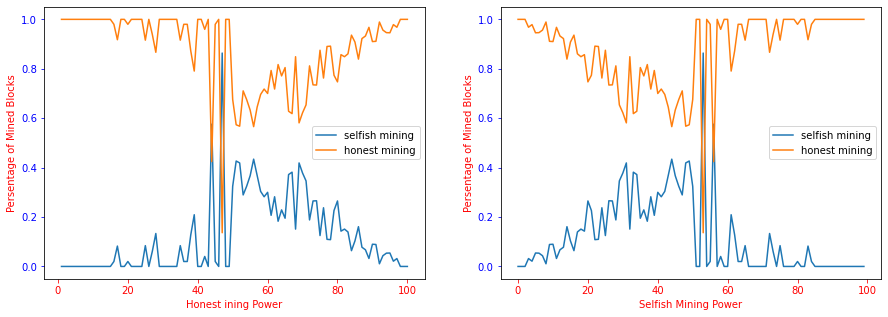

In [59]:
selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='blue')
axs[0].set_xlabel('Honest ining Power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='blue')
axs[1].set_xlabel('Selfish Mining Power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

In [50]:
import matplotlib.pyplot as plt

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)

    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    

Running simulation of mining power with:
-> 100 honest minors having 100% of total mining power
-> 0 selfish minors having 0% of total mining power
...
Honest profit: 1.0102040816326536
Selfish profit: 0
Total profit: 1.0102040816326536

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

Running simulation of mining power with:
-> 98 honest minors having 98% of total mining power
-> 2 selfish minors having 2% of total mining power
...
Honest profit: 0.9791666666666663
Selfish profit: 0.020833333333333332
Total profit: 0.9999999999999997

Running simulation of mining power with:
-> 97 honest minors having 97% of total mining power
-> 3 selfish minors having 3% of total mining power
...
Honest profit: 0.9898989898989893
Selfish profit: 0.010101010101010102
Total profit: 0.9999999999999993

Running simula

Honest profit: 0.779411764705882
Selfish profit: 0.22058823529411767
Total profit: 0.9999999999999997

Running simulation of mining power with:
-> 67 honest minors having 67% of total mining power
-> 33 selfish minors having 33% of total mining power
...
Honest profit: 0.7575757575757571
Selfish profit: 0.25757575757575757
Total profit: 1.0151515151515147

Running simulation of mining power with:
-> 66 honest minors having 66% of total mining power
-> 34 selfish minors having 34% of total mining power
...
Honest profit: 0.845070422535211
Selfish profit: 0.15492957746478875
Total profit: 0.9999999999999998

Running simulation of mining power with:
-> 65 honest minors having 65% of total mining power
-> 35 selfish minors having 35% of total mining power
...
Honest profit: 0.8428571428571421
Selfish profit: 0.15714285714285717
Total profit: 0.9999999999999992

Running simulation of mining power with:
-> 64 honest minors having 64% of total mining power
-> 36 selfish minors having 36% of t

Honest profit: 0.5405405405405406
Selfish profit: 0.43243243243243246
Total profit: 0.972972972972973

Running simulation of mining power with:
-> 34 honest minors having 34% of total mining power
-> 66 selfish minors having 66% of total mining power
...
Honest profit: 0.6046511627906977
Selfish profit: 0.4186046511627907
Total profit: 1.0232558139534884

Running simulation of mining power with:
-> 33 honest minors having 33% of total mining power
-> 67 selfish minors having 67% of total mining power
...
Honest profit: 0.5405405405405406
Selfish profit: 0.4864864864864865
Total profit: 1.0270270270270272

Running simulation of mining power with:
-> 32 honest minors having 32% of total mining power
-> 68 selfish minors having 68% of total mining power
...
Honest profit: 0.6410256410256411
Selfish profit: 0.358974358974359
Total profit: 1.0

Running simulation of mining power with:
-> 31 honest minors having 31% of total mining power
-> 69 selfish minors having 69% of total mining power


Honest profit: 0.0
Selfish profit: 1.0
Total profit: 1.0



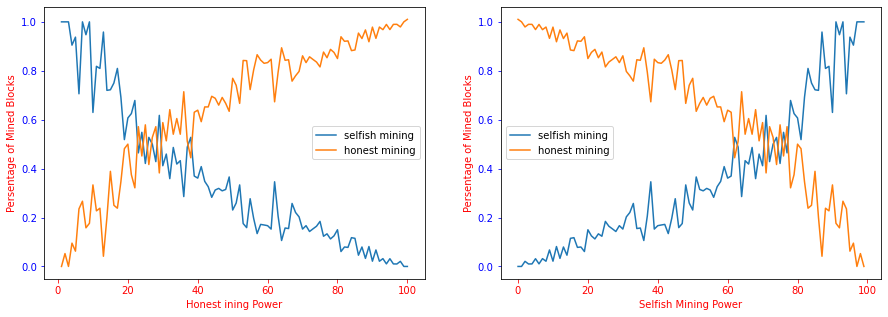

In [51]:
selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='blue')
axs[0].set_xlabel('Honest Mining Power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='blue')
axs[1].set_xlabel('Selfish Mining Power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()